In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.python.summary.summary_iterator import summary_iterator


PICS_DIR = 'Report/src/pics'

# Directory containing the experiment folders
runs_dir = 'runs'

In [2]:
def create_loss_figs(train_df, val_df, hue_col, axs, smoothing=0.9):
    
    train_df[hue_col] = train_df[hue_col].astype('str')
    val_df[hue_col] = val_df[hue_col].astype('str')
    hue_cols = sorted(val_df[hue_col].unique(), key=lambda x: int(x))
    
    train_df[f'smoothed_train_loss_{smoothing}'] = train_df.groupby(hue_col)['train_loss_'].transform(lambda x: smooth(x.tolist(), smoothing))
    
    sns.lineplot(data=train_df, x='step', y=f'smoothed_train_loss_{smoothing}', hue=hue_col, ax=axs[0], hue_order=hue_cols, palette='viridis')
    sns.lineplot(data=val_df, x='step', y=f'val_loss_', hue=hue_col, ax=axs[1], hue_order=hue_cols, palette='viridis')
    
    axs[0].set_xlabel('Step')
    axs[0].set_ylabel('Smoothed Train Loss')
    
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Validation Loss')
    
    plt.tight_layout()
    plt.show()

In [3]:
def create_accuracy_figs(train_df, val_df, hue_col, axs, smoothing=0.9):
    train_df[hue_col] = train_df[hue_col].astype('str')
    val_df[hue_col] = val_df[hue_col].astype('str')
    hue_cols = sorted(val_df[hue_col].unique(), key=lambda x: int(x))
    
    train_df[f'smoothed_train_accuracy_{smoothing}'] = train_df.groupby(hue_col)['train_accuracy'].transform(lambda x: smooth(x.tolist(), smoothing))
    # val_df[f'smoothed_val_accuracy_{smoothing}'] = val_df.groupby(hue_col)['val_accuracy'].transform(lambda x: smooth(x.tolist(), smoothing))
    
    sns.lineplot(data=train_df, x='step', y=f'smoothed_train_accuracy_{smoothing}', hue=hue_col, ax=axs[0], hue_order=hue_cols, palette='viridis')
    sns.lineplot(data=val_df, x='step', y=f'val_accuracy', hue=hue_col, ax=axs[1], hue_order=hue_cols, palette='viridis')
    
    axs[0].set_xlabel('Step')
    axs[0].set_ylabel('Smoothed Train Accuracy')
    
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Validation Accuracy')
    
    plt.tight_layout()
    plt.show()

In [4]:
train_data = []
val_data = []
test_data = []

# Iterate over each model directory in runs directory
for model_dir in os.listdir(runs_dir):
    model_path = os.path.join(runs_dir, model_dir)
    
    if os.path.isdir(model_path):
        for f in os.listdir(model_path):
            file_path = os.path.join(model_path, f)
            
            try:
                iterator = summary_iterator(file_path)
                for i, event in enumerate(iterator):
                    if event.summary and event.summary.value:
                        for value in event.summary.value:
                            data_entry = {
                                'step': event.step,
                                'wall_time': event.wall_time,
                                # 'wall_time_accuracy': event.wall_time,
                                'model': model_dir,
                                'tag': value.tag,
                                'value': value.simple_value
                            }
                            
                            if value.tag in ['Loss/train', 'Accuracy/train']:
                                train_data.append(data_entry)
                            elif value.tag in ['Loss/val', 'Accuracy/val']:
                                val_data.append(data_entry)
                            elif value.tag == 'Accuracy/test':
                                test_data.append(data_entry)
            except Exception as e:
                print(f'Error processing file {file_path}: {e}')

# Convert lists to DataFrames
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

train_df = train_df.pivot_table(index=['step', 'model'], columns='tag', values=['value', 'wall_time']).reset_index()
train_df.columns = ['step', 'model', 'train_accuracy', 'train_loss_', 'wall_time_accuracy', 'wall_time_loss']

val_df = val_df.pivot_table(index=['step', 'model'], columns='tag', values=['value', 'wall_time']).reset_index()
val_df.columns = ['step', 'model', 'val_accuracy', 'val_loss_', 'wall_time_accuracy', 'wall_time_loss']

test_df = test_df.drop(columns=['step', 'tag'], inplace=False)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [5]:
# Function toextract parameters from model column
def parse_model_column(model):
    match = re.match(r'(?P<dataset>.*)-kan-e\d+-l[\d_]+-g(?P<g>\d+)-k(?P<k>\d+)', model)
    if match:
        return match.group('dataset'), int(match.group('g')), int(match.group('k'))
    else:
        return None, None, None

In [6]:
for df in [train_df, val_df, test_df]:
    df[['dataset', 'grid_size', 'spline_order']] = df['model'].apply(lambda x: pd.Series(parse_model_column(x)))
    df['spline_order'] = df['spline_order'].astype(int)
    df['grid_size'] = df['grid_size'].astype(int)
    df['dataset'] = df['dataset'].astype('category')
    df.drop(columns=['model'], inplace=True)

In [7]:
# apply smoothing to scalars as in tensorboard (moving average)
def smooth(scalars: list, weight: float) -> list:
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

In [8]:
mnist_train_fixed_K = train_df.query('dataset == "mnist" and spline_order == 3').copy()
mnist_train_fixed_K = mnist_train_fixed_K[mnist_train_fixed_K['step'] <= 6000]
mnist_val_fixed_K = val_df.query('dataset == "mnist" and spline_order == 3').copy()
mnist_val_fixed_K = mnist_val_fixed_K[mnist_val_fixed_K['step'] <= 10]

### MNIST train and validation accuracy with varying grid size

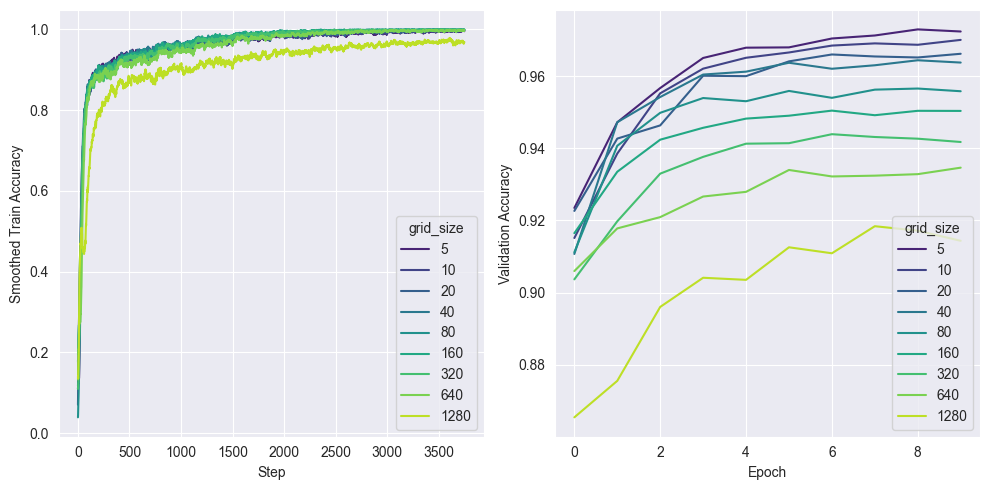

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
create_accuracy_figs(mnist_train_fixed_K, mnist_val_fixed_K, 'grid_size', axs, 0.9)
# fig.savefig(f'{PICS_DIR}/mnist_accuracy_grid_size.png')

### MNIST train and validation loss with varying grid size

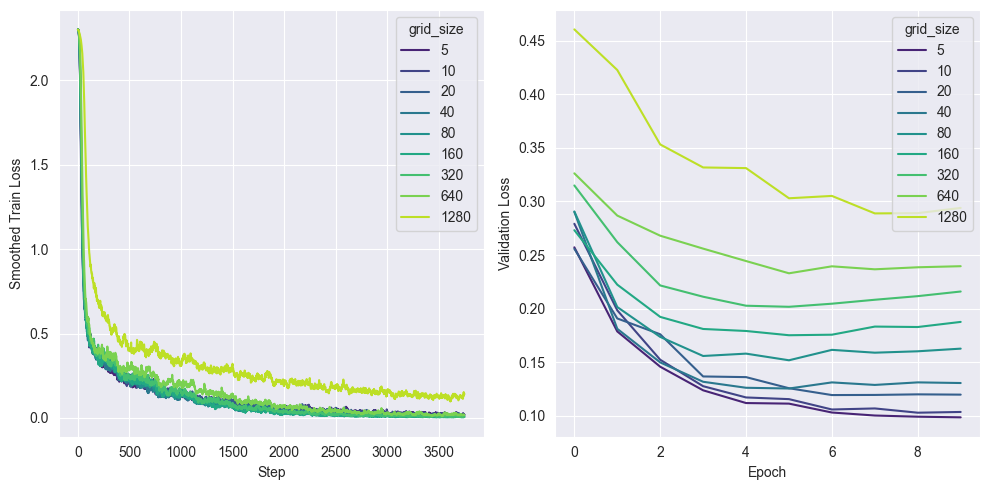

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
create_loss_figs(mnist_train_fixed_K, mnist_val_fixed_K, 'grid_size', axs, 0.9)
# fig.savefig(f'{PICS_DIR}/mnist_loss_grid_size.png')

In [11]:
cifar_train_fixed_K = train_df.query('dataset == "cifar10" and spline_order == 3').copy()
cifar_train_fixed_K = cifar_train_fixed_K[cifar_train_fixed_K['step'] <= 6000]
cifar_val_fixed_K = val_df.query('dataset == "cifar10" and spline_order == 3').copy()
cifar_val_fixed_K = cifar_val_fixed_K[cifar_val_fixed_K['step'] <= 10]

### CIFAR-10 traind and validation accuracy with varying grid size

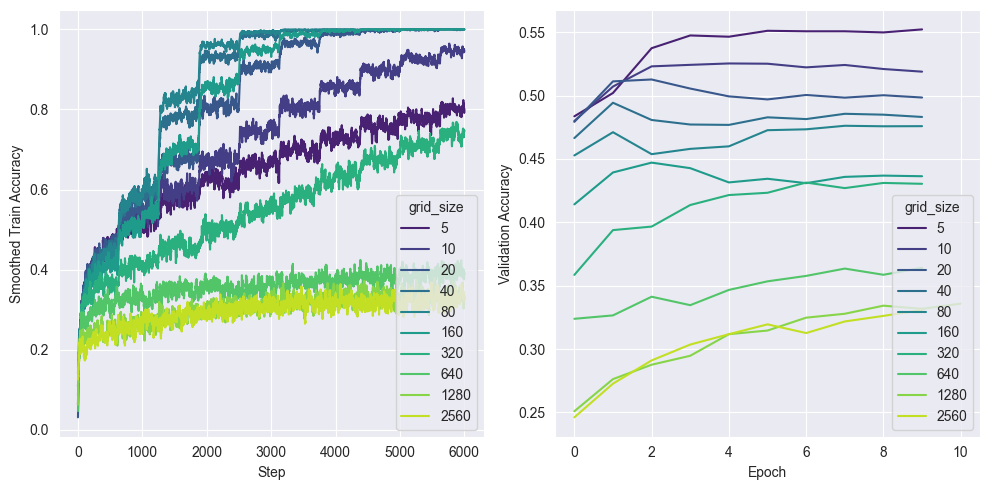

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
create_accuracy_figs(cifar_train_fixed_K, cifar_val_fixed_K, 'grid_size', axs)
# fig.savefig(f'{PICS_DIR}/cifar10_accuracy_grid_size.png')

### CIFAR-10 train and validation loss with varying grid size

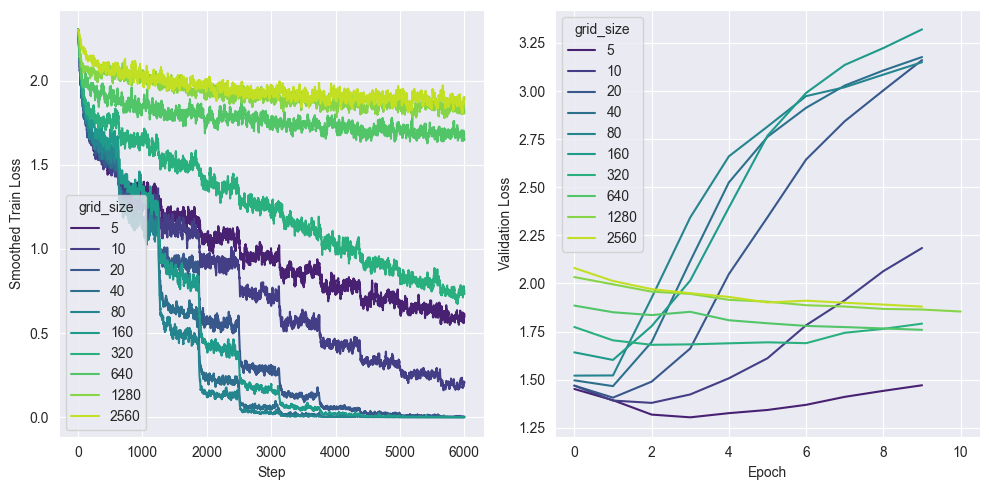

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
create_loss_figs(cifar_train_fixed_K, cifar_val_fixed_K, 'grid_size', axs)
# fig.savefig(f'{PICS_DIR}/cifar10_accuracy_grid_size.png')

In [14]:
cifar10_train = train_df.query('dataset == "cifar10" and grid_size == 5').copy()
cifar10_val = val_df.query('dataset == "cifar10" and grid_size == 5').copy()

### CIFAR-10 train and validation accuracy with varying spline order

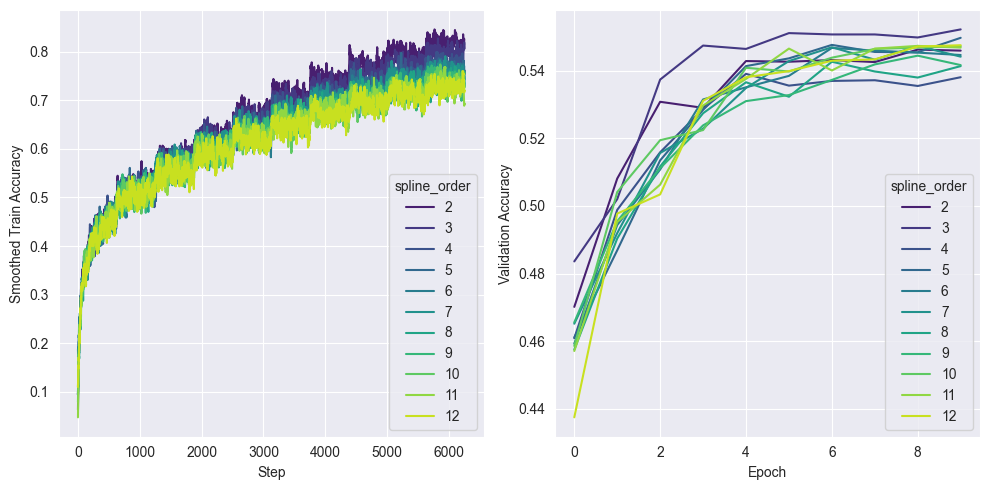

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
create_accuracy_figs(cifar10_train, cifar10_val, 'spline_order', axs)
# fig.savefig(f'{PICS_DIR}/cifar10_accuracy_spline_order.png')

### CIFAR-10 train and validation loss with varying spline order

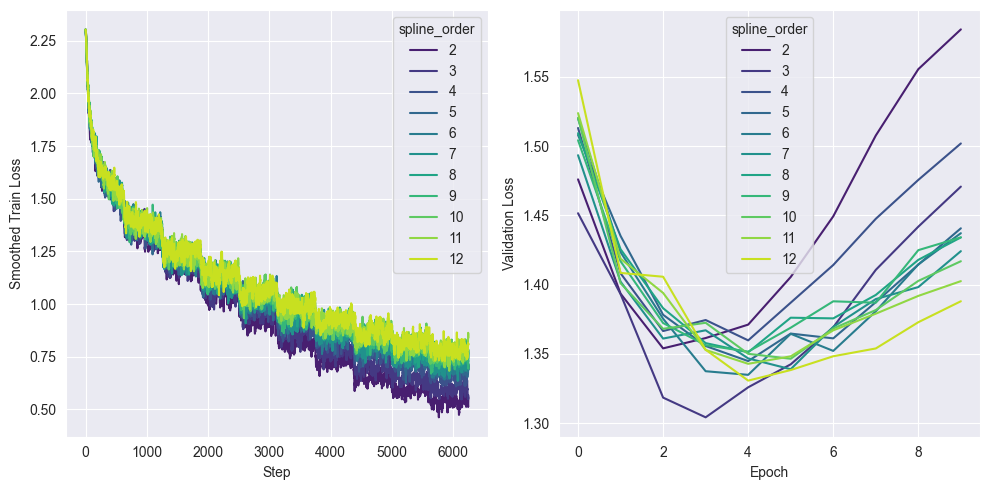

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
create_loss_figs(cifar10_train, cifar10_val, 'spline_order', axs, 0.9)
# fig.savefig(f'{PICS_DIR}/cifar10_loss_spline_order.png')

In [17]:
mnist_train_grid5 = train_df.query('dataset == "mnist" and grid_size == 5').copy()
mnist_val_grid5 = val_df.query('dataset == "mnist" and grid_size == 5').copy()

### MNIST train and validation accuracy with varying spline order

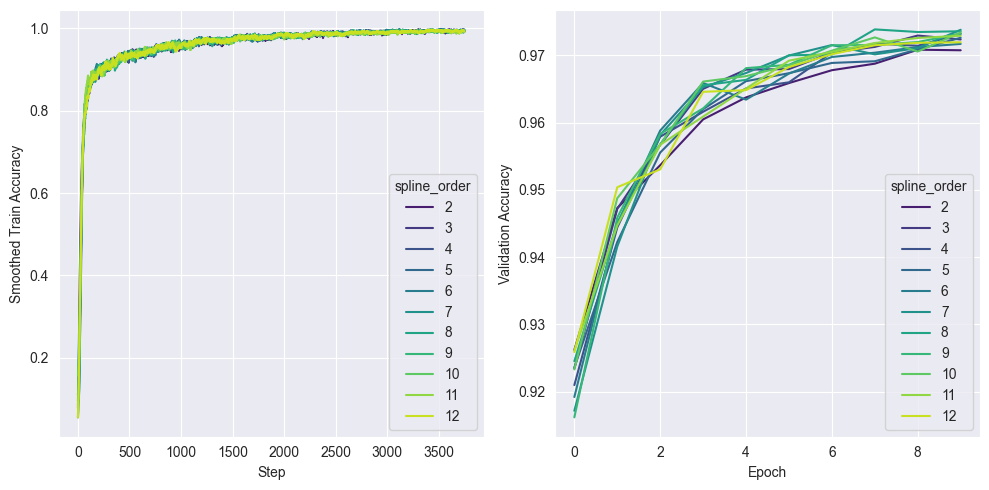

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
create_accuracy_figs(mnist_train_grid5, mnist_val_grid5, 'spline_order', axs)
# fig.savefig(f'{PICS_DIR}/mnist_accuracy_spline_order.png')

### MNIST train and validation loss with varying spline order

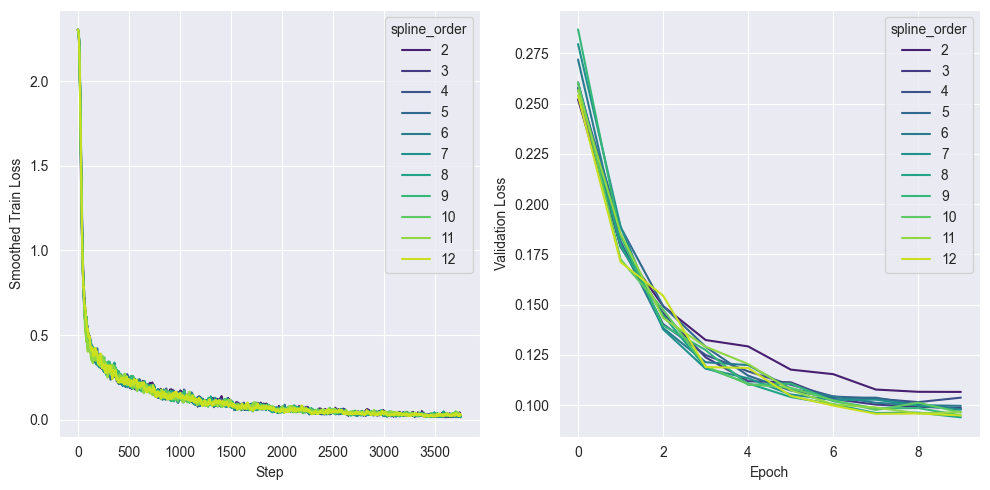

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
create_loss_figs(mnist_train_grid5, mnist_val_grid5, 'spline_order', axs, 0.9)
# fig.savefig(f'{PICS_DIR}/mnist_loss_spline_order.png')